In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

# Load preds

In [2]:
import json

RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_beam8-4_coherence_icl20_nohistory_20240814195949/outputs_val.json"
METRICS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_beam8-4_coherence_icl20_nohistory_20240814195949/metrics_coherence_nli_val.json"
preds = json.load(open(RESULTS_PATH, "r"))
coherence_metrics = json.load(open(METRICS_PATH, "r"))

# Look at cases with low relevance high informativeness

In [18]:
low_rel_low_info = []
low_rel_high_info = []
high_rel_low_info = []
high_rel_high_info = []

for output in preds.values():
    for question_idx in range(output['final_turn'] + 1):
        question = output['questions'][question_idx]
        answer = output['answers'][question_idx]
        selected_candidate_idx = output['candidate_questions'][question_idx].index(question)
        relevance = output['candidate_questions_scores'][question_idx][selected_candidate_idx]['relevance']
        informativeness = output['candidate_questions_scores'][question_idx][selected_candidate_idx]['informativeness_marginal']
        
        if relevance <= 0.2 and informativeness <= 0.2:
            low_rel_low_info.append((output['procedure'], question, answer))
        elif relevance <= 0.2 and informativeness >= 0.9:
            low_rel_high_info.append((output['procedure'], question, answer))
        elif relevance >= 0.9 and informativeness <= 0.2:
            high_rel_low_info.append((output['procedure'], question, answer))
        elif relevance >= 0.9 and informativeness >= 0.9:
            high_rel_high_info.append((output['procedure'], question, answer))
        
    

In [19]:
from travel.data.vqa import VQAResponse

from pprint import pprint

for procedure, question, answer in low_rel_high_info:
    print(f"{procedure} -> {question} {VQAResponse(answer).name}")

Sew the shoe with the thread and the awl in your hands -> Is the shoe in the process of being sewn? Yes
Insert the awl into the sandal -> Is the person holding the awl? Yes
Pull the thread -> Is the person holding the thread? Yes
Pull the thread -> Is the person's hand holding the thread? Yes
Clean the clay box with sand -> Is the person working on the procedure "Clean the clay box with sand"? Yes
Pick brush -> Is the person's hand holding the brush? Yes
Drop the towel on the chair -> Is the towel on the floor? No
Close the pack of sauce -> Is the pack of sauce sitting on the table? Yes
Cut a leaf with a scissor -> Are the scissors open or closed? Yes
Place the wood piece on a wall -> Is the person holding the wood piece? Yes
Remove the piece of wood from the wood cutting machine -> Is the piece of wood on the ground? Yes
Drop the bucket on the table -> Is the bucket on the ground? No
Remove the cut piece of wood from the cutting machine -> Is there a cutting machine in the image? Yes


In [14]:
from travel.data.vqa import VQAResponse

from pprint import pprint

for procedure, question, answer in high_rel_low_info:
    print(f"{procedure} -> {question} {VQAResponse(answer).name}")

In [24]:
from scipy.stats import entropy

print(entropy([0.5, 0.5], [0.4, 0.6]))


def relative_entropy(binary_prob0, binary_prob1):
    p0a = binary_prob0
    p0b = 1.0 - binary_prob0
    
    p1a = binary_prob1
    p1b = 1.0 - binary_prob1
    
    ent = np.log2(p0a/p1a)

0.020410997260127586


# Look at how max number of iterations impacts accuracy

In [36]:
from collections import defaultdict
import numpy as np

n_turns = []
success_probs_by_turn = defaultdict(list)
for output in preds.values():
    n_turns.append(output['final_turn'] + 1)
    for question_idx in range(10):
        this_question_idx = min(output['final_turn'], question_idx)
        
        question = output['questions'][this_question_idx]
        answer = output['answers'][this_question_idx]
        selected_candidate_idx = output['candidate_questions'][this_question_idx].index(question)
        relevance = output['candidate_questions_scores'][this_question_idx][selected_candidate_idx]['relevance']
        informativeness = output['candidate_questions_scores'][this_question_idx][selected_candidate_idx]['informativeness_marginal']
        
        success_prob = output['success_probs'][this_question_idx]
        success_probs_by_turn[question_idx].append(success_prob)
        
print("Average number of turns:", np.mean(n_turns))
print("Number of probs per turn:", [len(success_probs_by_turn[question_idx]) for question_idx in success_probs_by_turn])


Average number of turns: 3.828
Number of probs per turn: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


In [37]:
from pprint import pprint

from travel.model.mistake_detection import MISTAKE_DETECTION_THRESHOLDS
from travel.model.metrics import mistake_detection_metrics

all_labels_binary = [output['mistake'] for output in preds.values()]

accuracy_metrics_by_question_idx = []
for question_idx in success_probs_by_turn:
    all_probs = success_probs_by_turn[question_idx]
    
    # Calculate accuracy metrics
    best_metrics = None
    best_threshold = None
    accuracy_metrics_by_threshold = {}
    coherence_metrics_by_threshold = {}
    for threshold in MISTAKE_DETECTION_THRESHOLDS:
        threshold_preds = [1.0 - p >= threshold for p in all_probs] # Have to do 1.0 - probability since we got "success" probability from VLM
        assert len(threshold_preds) == len(all_probs) == len(all_labels), "Expected same number of preds, probs, and labels."
        this_metrics = mistake_detection_metrics(all_labels_binary, threshold_preds)
        accuracy_metrics_by_threshold[threshold] = this_metrics

        if best_metrics is None or (this_metrics['false_positive_rate'] + this_metrics['false_negative_rate']) < (best_metrics['false_positive_rate'] + best_metrics['false_negative_rate']):
            best_metrics = this_metrics
            best_threshold = threshold

    accuracy_metrics_by_threshold['best_metrics'] = best_metrics
    accuracy_metrics_by_threshold['best_threshold'] = best_threshold
    
    accuracy_metrics_by_question_idx.append(accuracy_metrics_by_threshold)


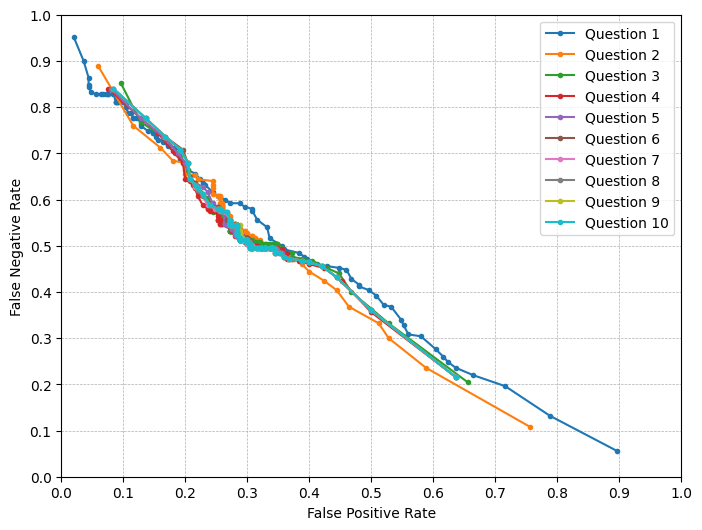

In [38]:
from travel.model.metrics import generate_det_curves

generate_det_curves(accuracy_metrics_by_question_idx, curve_names=[f"Question {question_idx+1}" for question_idx in range(len(accuracy_metrics_by_question_idx))], save_paths=[])

# Analysis on disagreements between VLM coherence metrics vs. NLI coherence metrics (8/14/2024)

In [8]:
from collections import defaultdict
from tqdm import tqdm

from travel.model.metrics import question_coherence_metrics_vlm

new_outputs = []
for example_idx, (example_id, output) in tqdm(enumerate(list(preds.items()))):
    output = {'example_id': example_id} | output
    
    coherence_metrics_nli = defaultdict(list)

    vlm_metrics = question_coherence_metrics_vlm([output['success_probs']], [output['success_probs_negated']])
    coherence_metrics_vlm = {}
    coherence_metrics_vlm['relevance_marginal'] = vlm_metrics['relevance_marginal']
    coherence_metrics_vlm['informativeness_marginal'] = vlm_metrics['informativeness_marginal']
    coherence_metrics_vlm['informativeness_marginal_x_relevance_marginal'] = vlm_metrics['informativeness_marginal_x_relevance_marginal']
    
    for question_idx in range(output['final_turn'] + 1):
        
        question = output['questions'][question_idx]
        answer = output['answers'][question_idx]

        relevance = coherence_metrics['metrics_by_turn']['relevance_marginal_by_turn'][example_idx][question_idx]
        informativeness = coherence_metrics['metrics_by_turn']['informativeness_marginal_by_turn'][example_idx][question_idx]
        informativeness_x_relevance = coherence_metrics['metrics_by_turn']['informativeness_marginal_x_relevance_marginal_by_turn'][example_idx][question_idx]
        informativeness_x_relevance_reweight = coherence_metrics['metrics_by_turn']['informativeness_marginal_x_relevance_marginal_vlm_reweight_by_turn'][example_idx][question_idx]      
        
        coherence_metrics_nli['relevance_marginal'].append(relevance)
        coherence_metrics_nli['informativeness_marginal'].append(informativeness)
        coherence_metrics_nli['informativeness_marginal_x_relevance_marginal'].append(informativeness_x_relevance)
        coherence_metrics_nli['informativeness_marginal_x_relevance_marginal_vlm_reweight'].append(informativeness_x_relevance_reweight)
        
        output['coherence_nli'] = coherence_metrics_nli
        output['coherence_vlm'] = coherence_metrics_vlm
        
        
    new_outputs.append(output)

500it [00:00, 4148.94it/s]


In [9]:
import matplotlib.pyplot as plt
import os
from PIL import Image
from pprint import pprint
import random

random_outputs_to_visualize = random.sample(new_outputs, 20)

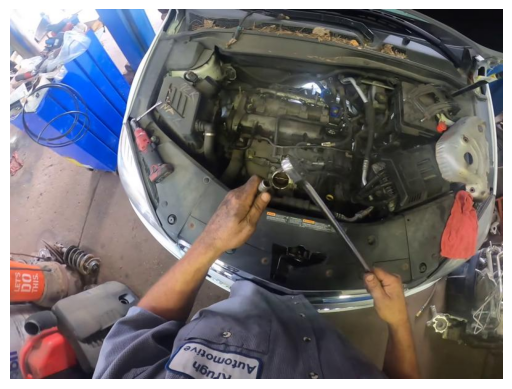

Procedure: Pick the torque wrench (success: None)
Q1: Is the torque wrench in the person's hand?
A1: Yes ([0.069542, 0.930458])
Success probability 1: 0.966156

Coherence Metrics:
	Marginal Relevance (NLI): 0.935547
	Marginal Relevance (VLM): 0.846953

	Marginal Informativeness (NLI): 0.704102
	Marginal Informativeness (VLM): 0.786683

	Marginal Relevance x Marginal Informativeness (NLI): 0.658691
	Marginal Relevance x Marginal Informativeness (VLM): 0.666283

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.418788








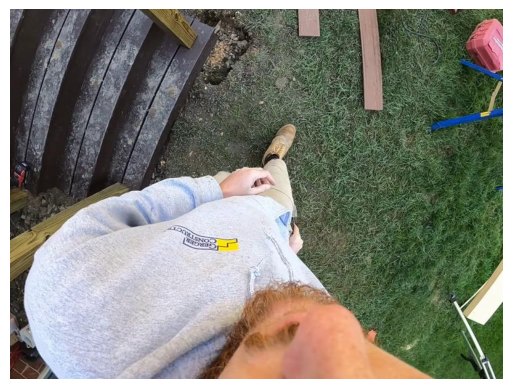

Procedure: Trim the grass (mistake: MisalignSRL_V_ARG1)
Q1: Is the grass trimmed?
A1: Yes ([0.236516, 0.763484])
Success probability 1: 0.982955

Coherence Metrics:
	Marginal Relevance (NLI): 0.998047
	Marginal Relevance (VLM): 0.957776

	Marginal Informativeness (NLI): 0.979492
	Marginal Informativeness (VLM): 0.875489

	Marginal Relevance x Marginal Informativeness (NLI): 0.977539
	Marginal Relevance x Marginal Informativeness (VLM): 0.838522

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.206067








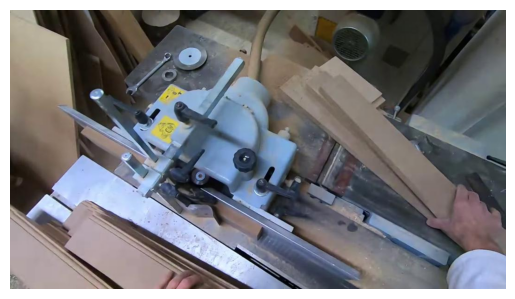

Procedure: Sand the second piece of wood with the electric sander in your hand (mistake: MisalignSRL_V)
Q1: Is the person holding the electric sander in his hand?
A1: Yes ([0.196826, 0.803174])
Success probability 1: 0.68763

Coherence Metrics:
	Marginal Relevance (NLI): 0.812012
	Marginal Relevance (VLM): 0.604933

	Marginal Informativeness (NLI): 0.799316
	Marginal Informativeness (VLM): 0.10411

	Marginal Relevance x Marginal Informativeness (NLI): 0.648926
	Marginal Relevance x Marginal Informativeness (VLM): 0.062979

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.184597


Q2: Is the electric sander in the person's hand?
A2: Yes ([0.33112, 0.66888])
Success probability 2: 0.874935

Coherence Metrics:
	Marginal Relevance (NLI): 0.910156
	Marginal Relevance (VLM): 0.680567

	Marginal Informativeness (NLI): 0.959473
	Marginal Informativeness (VLM): 0.456253

	Marginal Relevance x Marginal Informativeness (NLI): 0.873047
	Marginal Relevance x Marginal Informat

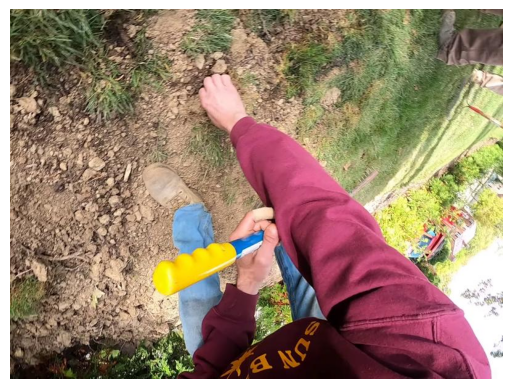

Procedure: Cut the grass with the lawn mower (mistake: MisalignSRL_V)
Q1: Is there a lawn mower?
A1: No ([0.709019, 0.290981])
Success probability 1: 0.004646

Coherence Metrics:
	Marginal Relevance (NLI): 0.689453
	Marginal Relevance (VLM): 0.713948

	Marginal Informativeness (NLI): 0.98877
	Marginal Informativeness (VLM): 0.957307

	Marginal Relevance x Marginal Informativeness (NLI): 0.681641
	Marginal Relevance x Marginal Informativeness (VLM): 0.683468

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.088623








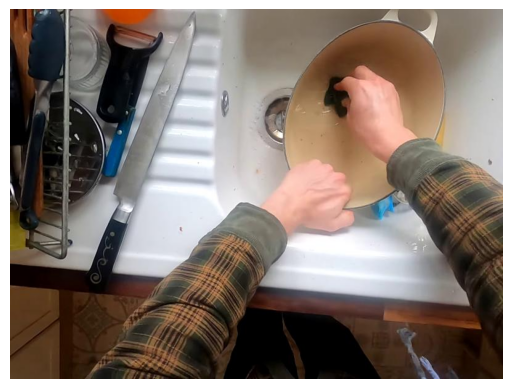

Procedure: Drop the twigs in the dustbin (mistake: MisalignSRL_V_ARG1)
Q1: Are the twigs in the dustbin?
A1: Unsure ([0.546738, 0.453262])
Success probability 1: 0.117572

Coherence Metrics:
	Marginal Relevance (NLI): 0.961914
	Marginal Relevance (VLM): 0.084241

	Marginal Informativeness (NLI): 0.768555
	Marginal Informativeness (VLM): 0.477659

	Marginal Relevance x Marginal Informativeness (NLI): 0.739258
	Marginal Relevance x Marginal Informativeness (VLM): 0.040238

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.004666


Q2: Is the dustbin open?
A2: No ([0.68595, 0.314051])
Success probability 2: 0.061424

Coherence Metrics:
	Marginal Relevance (NLI): 0.62207
	Marginal Relevance (VLM): 0.123344

	Marginal Informativeness (NLI): 0.735352
	Marginal Informativeness (VLM): 0.666928

	Marginal Relevance x Marginal Informativeness (NLI): 0.45752
	Marginal Relevance x Marginal Informativeness (VLM): 0.082262

	Marginal Relevance x Marginal Informativeness, VLM re

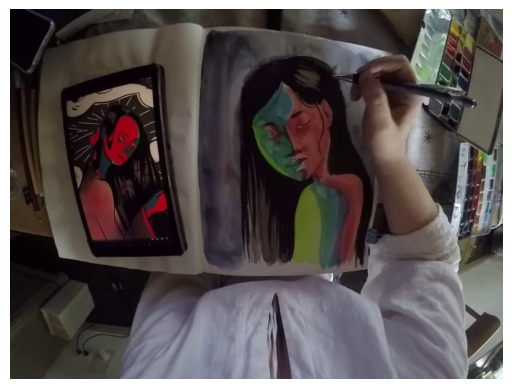

Procedure: Lift the pen in your hand from the painting (success: None)
Q1: Has the pen been lifted from the painting?
A1: Unsure ([0.48438, 0.51562])
Success probability 1: 0.111241

Coherence Metrics:
	Marginal Relevance (NLI): 0.998047
	Marginal Relevance (VLM): 0.133844

	Marginal Informativeness (NLI): 0.98877
	Marginal Informativeness (VLM): 0.496352

	Marginal Relevance x Marginal Informativeness (NLI): 0.986816
	Marginal Relevance x Marginal Informativeness (VLM): 0.066434

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.000695


Q2: Is the pen still touching the painting?
A2: Yes ([0.148047, 0.851953])
Success probability 2: 0.071591

Coherence Metrics:
	Marginal Relevance (NLI): 0.990723
	Marginal Relevance (VLM): 0.252644

	Marginal Informativeness (NLI): 0.941406
	Marginal Informativeness (VLM): 0.628167

	Marginal Relevance x Marginal Informativeness (NLI): 0.932617
	Marginal Relevance x Marginal Informativeness (VLM): 0.158703

	Marginal Relevance x

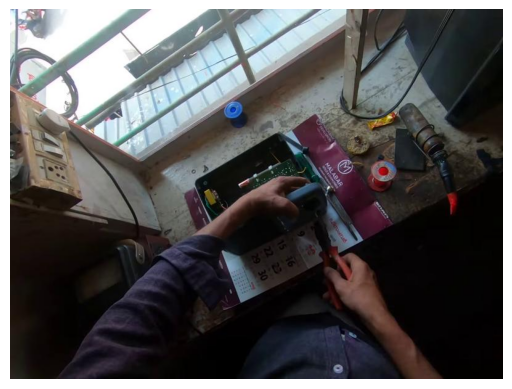

Procedure: Pick a pliers (success: None)
Q1: Do you see a pliers anywhere?
A1: Yes ([0.044019, 0.955981])
Success probability 1: 0.831143

Coherence Metrics:
	Marginal Relevance (NLI): 0.718262
	Marginal Relevance (VLM): 0.783006

	Marginal Informativeness (NLI): 0.971191
	Marginal Informativeness (VLM): 0.344917

	Marginal Relevance x Marginal Informativeness (NLI): 0.697754
	Marginal Relevance x Marginal Informativeness (VLM): 0.270072

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.516041


Q2: Is the pliers in someone's hand?
A2: Yes ([0.039048, 0.960952])
Success probability 2: 0.954647

Coherence Metrics:
	Marginal Relevance (NLI): 0.637695
	Marginal Relevance (VLM): 0.823474

	Marginal Informativeness (NLI): 0.785156
	Marginal Informativeness (VLM): 0.733681

	Marginal Relevance x Marginal Informativeness (NLI): 0.500488
	Marginal Relevance x Marginal Informativeness (VLM): 0.604167

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0

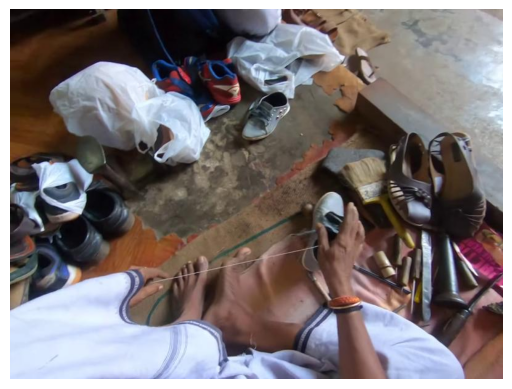

Procedure: Pick an hammer from the table with your hand (mistake: MisalignSRL_V_ARG1)
Q1: Is the hammer in the person's hand?
A1: Yes ([0.370225, 0.629775])
Success probability 1: 0.9659

Coherence Metrics:
	Marginal Relevance (NLI): 0.98584
	Marginal Relevance (VLM): 0.919866

	Marginal Informativeness (NLI): 0.934082
	Marginal Informativeness (VLM): 0.785446

	Marginal Relevance x Marginal Informativeness (NLI): 0.920898
	Marginal Relevance x Marginal Informativeness (VLM): 0.722505

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.045267








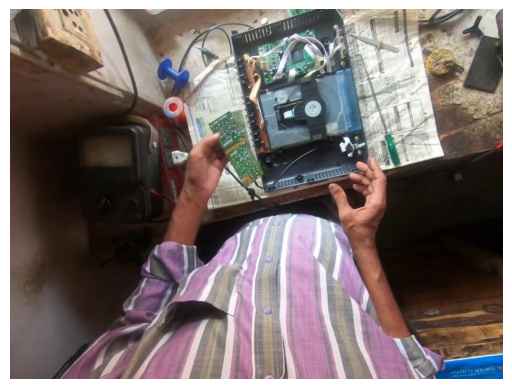

Procedure: Hold circuit board (success: None)
Q1: Is the person holding the circuit board?
A1: Yes ([0.096706, 0.903294])
Success probability 1: 0.979668

Coherence Metrics:
	Marginal Relevance (NLI): 0.911621
	Marginal Relevance (VLM): 0.913099

	Marginal Informativeness (NLI): 0.720703
	Marginal Informativeness (VLM): 0.856699

	Marginal Relevance x Marginal Informativeness (NLI): 0.657227
	Marginal Relevance x Marginal Informativeness (VLM): 0.782251

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.355911








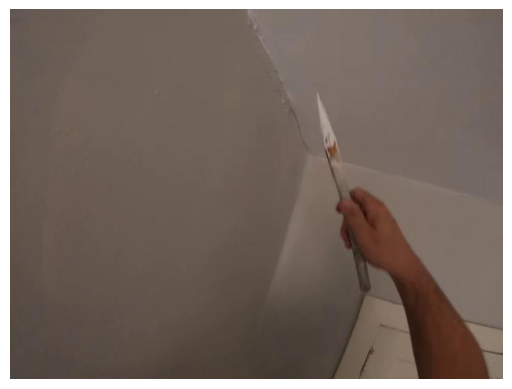

Procedure: Paint the watercolor on the stone with a paint brush (mistake: MisalignSRL_ARG1)
Q1: Is the watercolor on the stone?
A1: Yes ([0.26588, 0.73412])
Success probability 1: 0.97631

Coherence Metrics:
	Marginal Relevance (NLI): 0.982422
	Marginal Relevance (VLM): 0.957763

	Marginal Informativeness (NLI): 0.886719
	Marginal Informativeness (VLM): 0.838315

	Marginal Relevance x Marginal Informativeness (NLI): 0.871094
	Marginal Relevance x Marginal Informativeness (VLM): 0.802907

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.143303








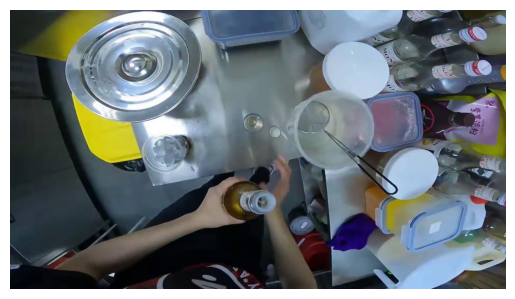

Procedure: Drop   a   bottle top on the countertop (success: None)
Q1: Is the bottle top on the countertop?
A1: Yes ([0.120853, 0.879147])
Success probability 1: 0.917303

Coherence Metrics:
	Marginal Relevance (NLI): 0.958984
	Marginal Relevance (VLM): 0.891738

	Marginal Informativeness (NLI): 0.787598
	Marginal Informativeness (VLM): 0.588388

	Marginal Relevance x Marginal Informativeness (NLI): 0.755371
	Marginal Relevance x Marginal Informativeness (VLM): 0.524688

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.353659








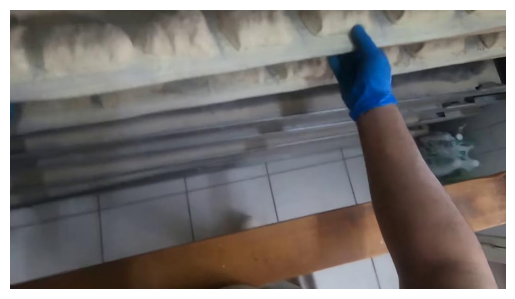

Procedure: Unroll the thread on the bed with your hand (mistake: MisalignSRL_V_ARG1)
Q1: Is the person's hand on the bed?
A1: Yes ([0.177811, 0.822189])
Success probability 1: 0.741674

Coherence Metrics:
	Marginal Relevance (NLI): 0.705566
	Marginal Relevance (VLM): 0.606898

	Marginal Informativeness (NLI): 0.809082
	Marginal Informativeness (VLM): 0.17579

	Marginal Relevance x Marginal Informativeness (NLI): 0.570801
	Marginal Relevance x Marginal Informativeness (VLM): 0.106687

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.185359


Q2: Is the thread unrolled?
A2: Unsure ([0.453262, 0.546738])
Success probability 2: 0.309024

Coherence Metrics:
	Marginal Relevance (NLI): 0.905273
	Marginal Relevance (VLM): 0.079594

	Marginal Informativeness (NLI): 0.559082
	Marginal Informativeness (VLM): 0.107956

	Marginal Relevance x Marginal Informativeness (NLI): 0.506348
	Marginal Relevance x Marginal Informativeness (VLM): 0.008593

	Marginal Relevance x Marginal 

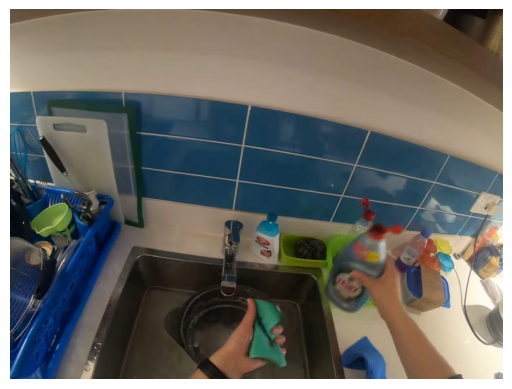

Procedure: Pour soap on the sponge from the bottle in your hand (success: None)
Q1: Is the bottle in the person's hand?
A1: Yes ([0.144149, 0.855851])
Success probability 1: 0.494141

Coherence Metrics:
	Marginal Relevance (NLI): 0.791992
	Marginal Relevance (VLM): 0.41718

	Marginal Informativeness (NLI): 0.794434
	Marginal Informativeness (VLM): 9.9e-05

	Marginal Relevance x Marginal Informativeness (NLI): 0.629395
	Marginal Relevance x Marginal Informativeness (VLM): 4.1e-05

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.254903


Q2: Is there soap on the sponge?
A2: Yes ([0.214691, 0.785309])
Success probability 2: 0.96862

Coherence Metrics:
	Marginal Relevance (NLI): 0.925293
	Marginal Relevance (VLM): 0.960043

	Marginal Informativeness (NLI): 0.644043
	Marginal Informativeness (VLM): 0.798734

	Marginal Relevance x Marginal Informativeness (NLI): 0.595703
	Marginal Relevance x Marginal Informativeness (VLM): 0.766819

	Marginal Relevance x Marginal Inf

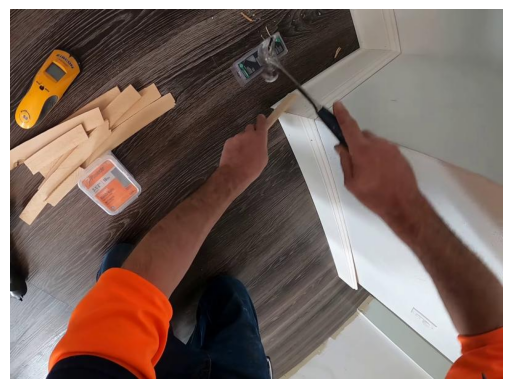

Procedure: Hit the stick with the hammer (success: None)
Q1: Is the hammer in the person's hand?
A1: Yes ([0.150029, 0.849971])
Success probability 1: 0.571767

Coherence Metrics:
	Marginal Relevance (NLI): 0.591797
	Marginal Relevance (VLM): 0.519922

	Marginal Informativeness (NLI): 0.804199
	Marginal Informativeness (VLM): 0.014913

	Marginal Relevance x Marginal Informativeness (NLI): 0.47583
	Marginal Relevance x Marginal Informativeness (VLM): 0.007753

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.185615


Q2: Is the stick being hit by the hammer?
A2: Yes ([0.307358, 0.692642])
Success probability 2: 0.908618

Coherence Metrics:
	Marginal Relevance (NLI): 0.757812
	Marginal Relevance (VLM): 0.875532

	Marginal Informativeness (NLI): 0.47998
	Marginal Informativeness (VLM): 0.558934

	Marginal Relevance x Marginal Informativeness (NLI): 0.36377
	Marginal Relevance x Marginal Informativeness (VLM): 0.489365

	Marginal Relevance x Marginal Informativeness,

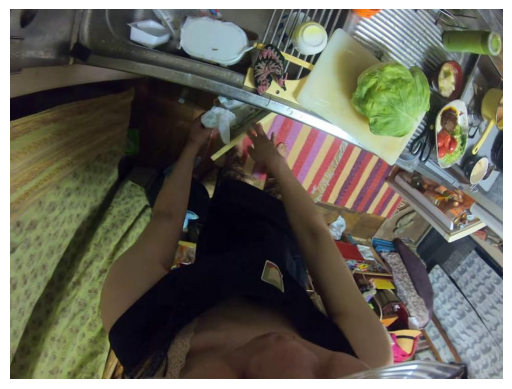

Procedure: Pick another nylon from the cupboard with your hand (success: None)
Q1: Is the person's hand visible in the photo?
A1: Yes ([0.160266, 0.839734])
Success probability 1: 0.409221

Coherence Metrics:
	Marginal Relevance (NLI): 0.212402
	Marginal Relevance (VLM): 0.313872

	Marginal Informativeness (NLI): 0.816406
	Marginal Informativeness (VLM): 0.02391

	Marginal Relevance x Marginal Informativeness (NLI): 0.173462
	Marginal Relevance x Marginal Informativeness (VLM): 0.007505

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.063323


Q2: Is the person's hand holding a nylon from the cupboard?
A2: Yes ([0.396068, 0.603932])
Success probability 2: 0.938124

Coherence Metrics:
	Marginal Relevance (NLI): 0.518555
	Marginal Relevance (VLM): 0.911769

	Marginal Informativeness (NLI): 0.780273
	Marginal Informativeness (VLM): 0.665153

	Marginal Relevance x Marginal Informativeness (NLI): 0.404541
	Marginal Relevance x Marginal Informativeness (VLM): 0.606466

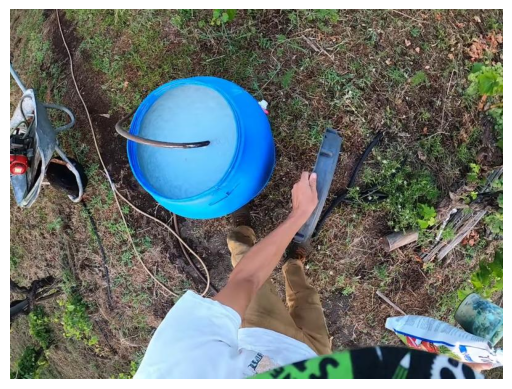

Procedure: Pull out a nail from a rim cap with the plier (mistake: MisalignSRL_V_ARG1)
Q1: Is there a rim cap?
A1: Yes ([0.359364, 0.640636])
Success probability 1: 0.317426

Coherence Metrics:
	Marginal Relevance (NLI): 0.5625
	Marginal Relevance (VLM): 0.267095

	Marginal Informativeness (NLI): 0.794434
	Marginal Informativeness (VLM): 0.09844

	Marginal Relevance x Marginal Informativeness (NLI): 0.446777
	Marginal Relevance x Marginal Informativeness (VLM): 0.026293

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.025844


Q2: Is there a nail?
A2: No ([0.603932, 0.396068])
Success probability 2: 0.016785

Coherence Metrics:
	Marginal Relevance (NLI): 0.473633
	Marginal Relevance (VLM): 0.675857

	Marginal Informativeness (NLI): 0.940918
	Marginal Informativeness (VLM): 0.877013

	Marginal Relevance x Marginal Informativeness (NLI): 0.445557
	Marginal Relevance x Marginal Informativeness (VLM): 0.592735

	Marginal Relevance x Marginal Informativeness, VLM rew

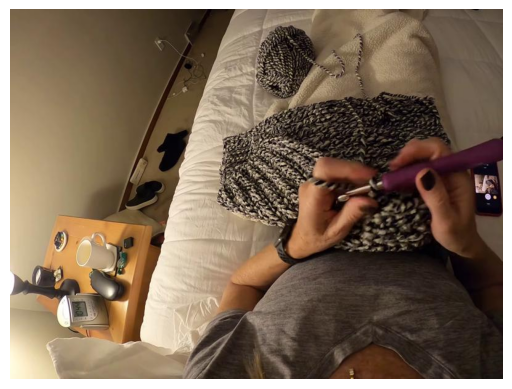

Procedure: Pull the yarn with your hand (success: None)
Q1: Is the person holding the yarn with their hand?
A1: Yes ([0.082697, 0.917303])
Success probability 1: 0.891811

Coherence Metrics:
	Marginal Relevance (NLI): 0.875
	Marginal Relevance (VLM): 0.747662

	Marginal Informativeness (NLI): 0.727051
	Marginal Informativeness (VLM): 0.505571

	Marginal Relevance x Marginal Informativeness (NLI): 0.63623
	Marginal Relevance x Marginal Informativeness (VLM): 0.377996

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.37435


Q2: Is the yarn in the person's hand?
A2: Yes ([0.07921, 0.92079])
Success probability 2: 0.966914

Coherence Metrics:
	Marginal Relevance (NLI): 0.922363
	Marginal Relevance (VLM): 0.733208

	Marginal Informativeness (NLI): 0.971191
	Marginal Informativeness (VLM): 0.790361

	Marginal Relevance x Marginal Informativeness (NLI): 0.895996
	Marginal Relevance x Marginal Informativeness (VLM): 0.579499

	Marginal Relevance x Marginal Informativene

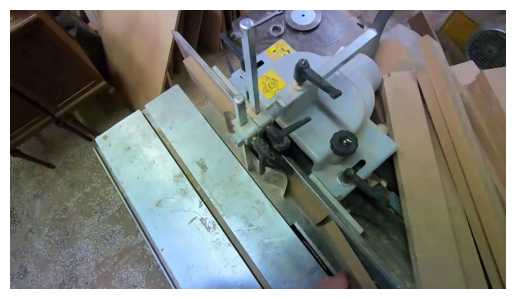

Procedure: Push the second piece of wood through the machine with your hands (mistake: Action Incomplete)
Q1: Is the person's hands visible in the photo?
A1: Yes ([0.177811, 0.822189])
Success probability 1: 0.620622

Coherence Metrics:
	Marginal Relevance (NLI): 0.496094
	Marginal Relevance (VLM): 0.543661

	Marginal Informativeness (NLI): 0.809082
	Marginal Informativeness (VLM): 0.042398

	Marginal Relevance x Marginal Informativeness (NLI): 0.401367
	Marginal Relevance x Marginal Informativeness (VLM): 0.02305

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.130338


Q2: Are the person's hands holding the second piece of wood?
A2: Yes ([0.217338, 0.782663])
Success probability 2: 0.9462

Coherence Metrics:
	Marginal Relevance (NLI): 0.515625
	Marginal Relevance (VLM): 0.849494

	Marginal Informativeness (NLI): 0.577148
	Marginal Informativeness (VLM): 0.697675

	Marginal Relevance x Marginal Informativeness (NLI): 0.297607
	Marginal Relevance x Marginal Info

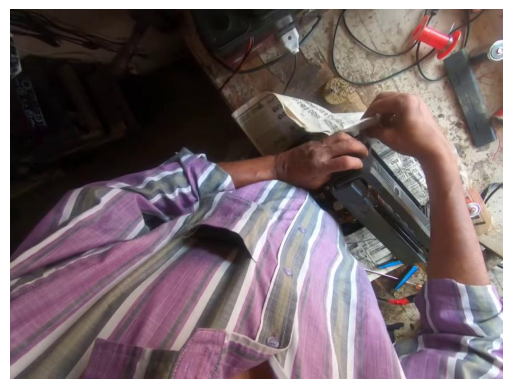

Procedure: Spread the portion of the newspaper on the dining table (mistake: MisalignSRL_V)
Q1: Is there a dining table?
A1: No ([0.73412, 0.26588])
Success probability 1: 0.01142

Coherence Metrics:
	Marginal Relevance (NLI): 0.53125
	Marginal Relevance (VLM): 0.461263

	Marginal Informativeness (NLI): 0.886719
	Marginal Informativeness (VLM): 0.909934

	Marginal Relevance x Marginal Informativeness (NLI): 0.471191
	Marginal Relevance x Marginal Informativeness (VLM): 0.419719

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.077515








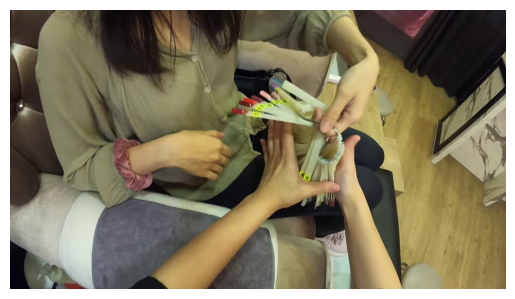

Procedure: Take the nails with your hands (success: None)
Q1: Is the person holding the nails in their hands?
A1: Yes ([0.105211, 0.894789])
Success probability 1: 0.823328

Coherence Metrics:
	Marginal Relevance (NLI): 0.930176
	Marginal Relevance (VLM): 0.746367

	Marginal Informativeness (NLI): 0.883789
	Marginal Informativeness (VLM): 0.327258

	Marginal Relevance x Marginal Informativeness (NLI): 0.822266
	Marginal Relevance x Marginal Informativeness (VLM): 0.244254

	Marginal Relevance x Marginal Informativeness, VLM reweighted (NLI): 0.423221


Q2: Are the nails in the person's hands?
A2: Yes ([0.228156, 0.771843])
Success probability 2: 0.937669

Coherence Metrics:
	Marginal Relevance (NLI): 0.947266
	Marginal Relevance (VLM): 0.799207

	Marginal Informativeness (NLI): 0.940918
	Marginal Informativeness (VLM): 0.663371

	Marginal Relevance x Marginal Informativeness (NLI): 0.891113
	Marginal Relevance x Marginal Informativeness (VLM): 0.53017

	Marginal Relevance x Marginal In

In [10]:
for output in random_outputs_to_visualize:
    
    frame_dir = os.path.join(output['frame_dir'], "frames")
    possible_frame_dirs = [frame_dir.replace("_debug250", f"_partition{i+1}of4") for i in range(4)]
    for pfd in possible_frame_dirs:
        try:
            frame_path = os.path.join(pfd, os.listdir(pfd)[0]) # only a single frame in frame dir
            frame = Image.open(frame_path)
            break
        except:
            continue
    plt.figure()
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    frame.close()

    print(f"Procedure: {output['procedure']} ({'mistake' if output['mistake'] else 'success'}: {output['mistake_type']})")
    for i in range(output['final_turn'] + 1):
        print(f"Q{i+1}: {output['questions'][i]}")
        print(f"A{i+1}: {output['answers'][i]} ({output['answer_probs'][i]})")
        print(f"Success probability {i+1}: {output['success_probs'][i]}")
        print("")
        print("Coherence Metrics:")
        print(f"\tMarginal Relevance (NLI): {output['coherence_nli']['relevance_marginal'][i]}")
        print(f"\tMarginal Relevance (VLM): {output['coherence_vlm']['relevance_marginal'][i]}")
        print("")
        print(f"\tMarginal Informativeness (NLI): {output['coherence_nli']['informativeness_marginal'][i]}")
        print(f"\tMarginal Informativeness (VLM): {output['coherence_vlm']['informativeness_marginal'][i]}")
        print("")
        print(f"\tMarginal Relevance x Marginal Informativeness (NLI): {output['coherence_nli']['informativeness_marginal_x_relevance_marginal'][i]}")
        print(f"\tMarginal Relevance x Marginal Informativeness (VLM): {output['coherence_vlm']['informativeness_marginal_x_relevance_marginal'][i]}")
        print("")
        print(f"\tMarginal Relevance x Marginal Informativeness, VLM reweighted (NLI): {output['coherence_nli']['informativeness_marginal_x_relevance_marginal_vlm_reweight'][i]}")

        print("\n")
    
    print("\n\n\n")